## Basic usage

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from remeta.gendata import simu_data
from remeta.plot import plot_psychometric, plot_link_function
from remeta.configuration import Configuration
from remeta import ReMeta
print('Imports succesful')
np.random.seed(1)
%load_ext autoreload
%autoreload 2


Imports succesful


Let's generate some data to work with. We will generate data based on a noisy-report model (`meta_noise_type='noisy-report'`), which assumes that the dominant source of metacognitive noise occurs at the reporting stage. We assume that metacognitive noise follows a beta distribution (`meta_noise_model='beta'`). In addition, we assume that our hypothetical observer aims at reporting probability correct (`meta_link_function='probability_correct'`).

In [49]:
options_basic = dict(
    meta_link_function='probability_correct',
    meta_noise_type='noisy_report',
    meta_noise_model='beta'
)

In a next step, we specify the parameters to be included in the generative model. By default, a parametery for sensory noise and metacognitive noise is enable, as well as parameters for a sensory bias and a confidence slope. Check out the `configuration.py` module for the `enable_XYZ` keywords. Each parameter can either be disabled (`enable_XYZ=0`), enabled (`enable_XYZ=1`) or enabled in duplex mode (`enable_XYZ=2`), which means that separate values are fitted depending on the sign of the stimulus (for sensory parameters) or the sign of the sensory decision value (for metacognitive parameters).

Here, we additionally enable the possibility of separate noise parameters for both stimulus categories (i.e. `enable_noise_sens=2`) and a metacognitive readout term (`enable_readout_term_meta=True`). For completeness, we define all available enable_XYZ keywords below, although it suffices to define those which differ from the default setting.

In [50]:
options_enable = dict(
    enable_warping_sens=0,
    enable_noise_sens=2,  # default 1
    enable_noise_multi_sens=0,
    enable_thresh_sens=0,
    enable_bias_sens=1,
    enable_noise_meta=1,
    enable_noise_multi_meta=0,
    enable_readout_term_meta=1,  # default 0
    enable_slope_meta=1,
    enable_scaling_meta=0,
    enable_criteria_meta=0,
    enable_levels_meta=0
)

Finally, we define _specific_ parameters values to sample data from the model defined above. We define `noise_sens` as a vector, whereby `noise_sens[0]` and `noise_sens[1]` correspond to the sensory noise for the negative and positive stimulus category, respectively.

In [51]:
params = dict(
    noise_sens=[0.3, 0.4],
    bias_sens=-0.1,
    noise_meta=0.2,
    readout_term_meta=-0.1,
    slope_meta=1.4,
)

We generate 2000 samples for a single participant.

In [52]:
data = simu_data(nsubjects=1, nsamples=2000, params=params, print_configuration=False, squeeze=True,
                 **options_basic, **options_enable)

	Performance: 87.50


<AxesSubplot:xlabel='Stimulus ($x$)', ylabel='Choice probability $S^+$'>

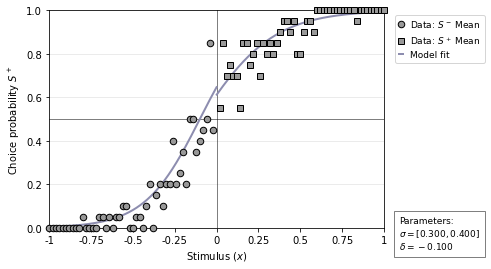

In [53]:
cfg = Configuration(**{**options_basic, **options_enable, 'print_configuration': False})
plot_psychometric(cfg, data.choices, data.stimuli, data.params_sens)

Define the model. Here we pass the true parameters as well, which is of course only possible with simulated data. We'll
come back to this later.

In [54]:
rem = ReMeta(true_params=params, **{**options_basic, **options_enable, 'print_configuration': False})

Fit the data:

In [55]:
rem.fit(data.stimuli, data.choices, data.confidence, verbose=False)

Obtain the fitting result:

In [56]:
result = rem.summary(extended=True)

The parameters are stored in the attribute `model`. Let's take a look at the fit for the sensory parameters:

In [57]:
for k, v in result.model.params_sens.items():
    print(f"{k} = [{', '.join([f'{p:.3f}' for p in v])}]" if hasattr(v, '__len__') else f"{k} = {v:.3f}")

noise_sens = [0.271, 0.385]
bias_sens = -0.080


This is not too bad. We have recovered the original parameters to some approximation. Nevertheless, the fitted parameters do not _exactly_ match our generative paramaeters. Since we passed the true parameters, the result object allows us to check whether this is because the optimization routine did not find the global minimum or whether the imprecision is in the data itself. Specifically, the result object contains both the likelihood of the fitted parameters and the likelihood of the true parameters:

In [58]:
print(f'Negative log-likelihood of true sensory parameters: {result.model.fit.fit_sens.negll_true:.1f}')
print(f'Negative log-likelihood of fitted sensory  parameters: {result.model.fit.fit_sens.negll:.1f}')

Negative log-likelihood of true sensory parameters: 573.4
Negative log-likelihood of fitted sensory  parameters: 570.1


The negative log-likelihood is smaller for the fitted parameters, i.e. the likelihood is higher for the fitted than the true parameters. We can thus be confident in the obtained parameters.

Next station - metacognitive parameters:

In [59]:
for k, v in result.model.params_meta.items():
    print(f"{k} = [{', '.join([f'{p:.3f}' for p in v])}]" if hasattr(v, '__len__') else f"{k} = {v:.3f}")

noise_meta = 0.199
readout_term_meta = -0.135
slope_meta = 1.587


In [60]:
print(f'Negative log-likelihood of true metacognitive parameters: {result.model.fit.fit_meta.negll_true:.1f}')
print(f'Negative log-likelihood of fitted metacognitive parameters: {result.model.fit.fit_meta.negll:.1f}')

Negative log-likelihood of true metacognitive parameters: 12534.3
Negative log-likelihood of fitted metacognitive parameters: 12530.4


Similar story! The recovered parameters are similar to the true parameters and the likelihhod is better for the fitted parameters.

Now for some plotting.

<AxesSubplot:xlabel='Sensory decision value ($y$)', ylabel='Confidence'>

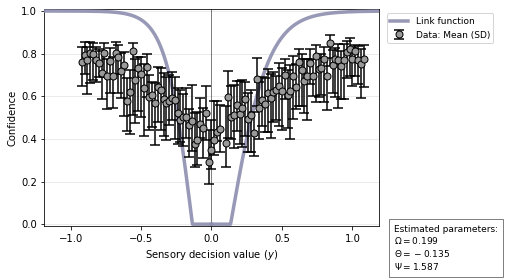

In [83]:
plot_link_function(cfg, data.stimuli, data.confidence, result.model.extended.dv_sens_mode,
                   result.model.params_sens, result.model.params_meta,
                   plot_likelihood=False, var_likelihood=result.model.extended.confidence,
                   noise_meta_transformed=result.model.extended.noise_meta, dv_range=(45, 50, 55))